# The Weeknd "Hurry Up Tomorrow" - Audio & Lyrical Analysis

This notebook performs a comprehensive analysis of The Weeknd's album "Hurry Up Tomorrow" by combining:
- **Spotify API data** (track metadata)
- **Genius API data** (lyrical sentiment analysis)
- **Local audio analysis** (tempo, acousticness, musical valence)
- **Statistical testing** (correlations, outliers, patterns)
- **Visualizations** (intensity maps, DNA charts, regression plots)

---

## Part 1: Spotify Track Metadata Extraction

The first step is to fetch the album's tracklist from Spotify using the Spotipy library. This gives us basic information like track names, track numbers, and unique Spotify IDs.


In [76]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

# 1. Setup your credentials
client_id = '5bb46020f8ce47968a90ddcd6456d29f'
client_secret = '8a3c739aadc24addbce5b1e30123df5b'

auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

# 2. Your chosen Album ID (Hurry Up Tomorrow)
album_id = '3OxfaVgvTxUTy7276t7SPU'

def get_album_tracklist(id):
    # Fetch track data from the API
    results = sp.album_tracks(id)
    tracks = results['items']
    
    # Handle pagination if the album has more than 50 tracks
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
        
    # Extract the specific fields we want
    track_data = []
    for track in tracks:
        track_data.append({
            'Track Number': track['track_number'],
            'Track Name': track['name'],
            'Unique ID': track['id']
        })
    
    # Create the DataFrame
    return pd.DataFrame(track_data)

# 3. Execute and display
df_tracks_HUT = get_album_tracklist(album_id)
print(df_tracks_HUT.head(10)) # Shows the first 10 tracks

   Track Number                                         Track Name  \
0             1                         Wake Me Up (feat. Justice)   
1             2                                         Cry For Me   
2             3                               I Can't Fucking Sing   
3             4                           São Paulo (feat. Anitta)   
4             5                           Until We're Skin & Bones   
5             6                                   Baptized In Fear   
6             7                                        Open Hearts   
7             8                                      Opening Night   
8             9  Reflections Laughing (feat. Travis Scott, Flor...   
9            10                      Enjoy The Show (feat. Future)   

                Unique ID  
0  5673WA8EEUSPx1ir26lhGW  
1  3AWDeHLc88XogCaCnZQLVI  
2  64JIAZ0bS7WoARYfWQGCoz  
3  7DY756WOLyOz2Xnhw4EFiC  
4  6jDGDtQPC46pFqxph3qdbD  
5  5rzI6Jnlhx8DgVgsOLorfW  
6  0sTBOp1hdayTjw6UOyPyi6  
7  4M

---

## Part 2: Lyrical Sentiment Analysis (DIY Valence)

This section analyzes the **emotional tone of the lyrics** using:
- **Genius API**: Fetches song lyrics
- **TextBlob**: Performs sentiment analysis on the lyrics
- **Polarity Score**: Returns a value from -1 (negative/sad) to +1 (positive/happy)

The code handles edge cases like instrumentals, missing lyrics, and API errors with protective delays to avoid rate limiting.

In [77]:
import lyricsgenius
from textblob import TextBlob
import time
import pandas as pd

# Initialize Genius
# Note: Keep your token secure!
GENIUS_TOKEN = "Zvj7PIh99StnhTbBVM_kEa_omsEXqiCxAXOsUI_qUueDShEtDj-g0jcH78_s4d9I"
genius = lyricsgenius.Genius(GENIUS_TOKEN)
genius.remove_section_headers = True 
genius.verbose = False 

def get_diy_valence(song_name, artist_name):
    # 1. CLEANING
    clean_name = song_name.split('(')[0].split('-')[0].strip()
    
    try:
        # 2. SEARCH
        song = genius.search_song(clean_name, artist_name)
        
        # 3. ROBUST CHECK: Is there a song AND does it have lyrics?
        if song and song.lyrics:
            # Check if lyrics are too short (indicates instrumental or error)
            if len(song.lyrics) < 20: 
                print(f"🎸 Instrumental detected: {clean_name}")
                return 0.0 # Neutral valence for instrumentals
            
            analysis = TextBlob(song.lyrics)
            return analysis.sentiment.polarity
        else:
            print(f"⚠️ No lyrics found for: {clean_name}")
            return 0.0 # Return neutral if not found
            
    except Exception as e:
        print(f"❌ Error fetching {clean_name}: {e}")
        return 0.0

# --- THE ROBUST LOOP ---
# We use all tracks now, not just head(5)
for index, row in df_tracks_HUT.iterrows():
    try:
        print(f"Processing {index+1}/{len(df_tracks_HUT)}: {row['Track Name']}...")
        val = get_diy_valence(row['Track Name'], "The Weeknd")
        df_tracks_HUT.at[index, 'diy_valence_lyrical'] = val
        
        # Protective delay so Genius doesn't ban our IP
        time.sleep(1.2) 
        
    except Exception as loop_error:
        print(f"CRITICAL ERROR on loop index {index}: {loop_error}")
        df_tracks_HUT.at[index, 'diy_valence_lyrical'] = 0.0
        continue # THIS is the magic word—it tells the code to skip to the next song

print("\n✅ Analysis Complete!")
print(df_tracks_HUT[['Track Number', 'Track Name', 'diy_valence_lyrical']].head(10))

Processing 1/22: Wake Me Up (feat. Justice)...
Processing 2/22: Cry For Me...
Processing 3/22: I Can't Fucking Sing...
Processing 4/22: São Paulo (feat. Anitta)...
Processing 5/22: Until We're Skin & Bones...
⚠️ No lyrics found for: Until We're Skin & Bones
Processing 6/22: Baptized In Fear...
Processing 7/22: Open Hearts...
Processing 8/22: Opening Night...
Processing 9/22: Reflections Laughing (feat. Travis Scott, Florence + The Machine)...
Processing 10/22: Enjoy The Show (feat. Future)...
Processing 11/22: Given Up On Me...
Processing 12/22: I Can't Wait To Get There...
Processing 13/22: Timeless (feat Playboi Carti)...
Processing 14/22: Niagara Falls...
Processing 15/22: Take Me Back To LA...
Processing 16/22: Big Sleep (feat. Giorgio Moroder)...
Processing 17/22: Give Me Mercy...
Processing 18/22: Drive...
Processing 19/22: The Abyss (feat. Lana Del Rey)...
Processing 20/22: Red Terror...
Processing 21/22: Without a Warning...
Processing 22/22: Hurry Up Tomorrow...

✅ Analysis Co

---

## Part 3: Local Audio Feature Extraction

This section analyzes the **actual audio files** (MP3s) using librosa to extract:

### 3.1 First Attempt: Tempo and Acousticness
- **Tempo (BPM)**: How fast the song is
- **Acousticness**: Ratio of harmonic (melodic) to total energy - indicates how "organic" vs "electronic" the track sounds

In [78]:
import librosa
import os
import pandas as pd
import numpy as np

# Point to your folder with the Weeknd MP3s
audio_folder = r'C:\Users\Syma\Documents\Naraviz\Investigations\Spotify Weekend DIscography\The Weeknd - Hurry Up Tomorrow'

def extract_local_features(file_path):
    try:
        # Load the full audio file
        y, sr = librosa.load(file_path)
        
        # 1. TEMPO (BPM)
        # beat_track returns the estimated tempo and the frames of each beat
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        
        # 2. DIY ACOUSTICNESS
        # We separate harmonic (melodic) from percussive (drum/beat) sounds
        y_harmonic, y_percussive = librosa.effects.hpss(y)
        # A simple ratio of harmonic energy to total energy can estimate "acoustic" feel
        harmonic_rms = np.mean(librosa.feature.rms(y=y_harmonic))
        total_rms = np.mean(librosa.feature.rms(y=y))
        acoustic_score = harmonic_rms / total_rms
        
        return float(tempo), float(acoustic_score)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

# List to store our local analysis
local_data = []

# Loop through the files in your folder
for filename in os.listdir(audio_folder):
    if filename.endswith(".mp3"):
        # Example: "01. Wake me up.mp3"
        track_number = int(filename.split('.')[0])
        path = os.path.join(audio_folder, filename)
        
        print(f"Analyzing Track {track_number}: {filename}...")
        tempo, acoustic = extract_local_features(path)
        
        local_data.append({
            'Track Number': track_number,
            'local_tempo': tempo,
            'local_acousticness': acoustic
        })

# Create a new DataFrame for local analysis
df_local_HUT = pd.DataFrame(local_data)

Analyzing Track 1: 01. Wake Me Up.mp3...


C:\Users\Syma\AppData\Local\Temp\ipykernel_18252\2351738770.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(tempo), float(acoustic_score)


Analyzing Track 2: 02. Cry For Me.mp3...
Analyzing Track 3: 03. I Can't Fucking Sing.mp3...
Analyzing Track 4: 04. São Paulo.mp3...
Analyzing Track 5: 05. Until We're Skin & Bones.mp3...
Analyzing Track 6: 06. Baptized In Fear.mp3...
Analyzing Track 7: 07. Open Hearts.mp3...
Analyzing Track 8: 08. Opening Night.mp3...
Analyzing Track 9: 09. Reflections Laughing.mp3...
Analyzing Track 10: 10. Enjoy The Show.mp3...
Analyzing Track 11: 11. Given Up On Me.mp3...
Analyzing Track 12: 12. I Can't Wait To Get There.mp3...
Analyzing Track 13: 13. Timeless.mp3...
Analyzing Track 14: 14. Niagara Falls.mp3...
Analyzing Track 15: 15. Take Me Back To LA.mp3...
Analyzing Track 16: 16. Big Sleep.mp3...
Analyzing Track 17: 17. Give Me Mercy.mp3...
Analyzing Track 18: 18. Drive.mp3...
Analyzing Track 19: 19. The Abyss.mp3...
Analyzing Track 20: 20. Red Terror.mp3...
Analyzing Track 21: 21. Without a Warning.mp3...
Analyzing Track 22: 22. Hurry Up Tomorrow.mp3...


### 3.2 Data Merge (Initial)
Combines the Spotify metadata with the local audio features using the track number as the key.

In [79]:
# Merge the Spotify data with the Local Audio data
df_final_HUT = pd.merge(df_tracks_HUT, df_local_HUT, on='Track Number', how='left')

# (Optional) If you have the sentiment data:
# df_final_HUT = pd.merge(df_final_HUT, df_sentiment, on='Track Number', how='left')

print(df_final_HUT.head())

   Track Number                  Track Name               Unique ID  \
0             1  Wake Me Up (feat. Justice)  5673WA8EEUSPx1ir26lhGW   
1             2                  Cry For Me  3AWDeHLc88XogCaCnZQLVI   
2             3        I Can't Fucking Sing  64JIAZ0bS7WoARYfWQGCoz   
3             4    São Paulo (feat. Anitta)  7DY756WOLyOz2Xnhw4EFiC   
4             5    Until We're Skin & Bones  6jDGDtQPC46pFqxph3qdbD   

   diy_valence_lyrical  local_tempo  local_acousticness  
0             0.144646   112.347147            0.755184  
1             0.083258   117.453835            0.876800  
2            -0.233333   117.453835            0.636278  
3             0.287500   129.199219            0.754143  
4             0.000000   129.199219            0.688574  


### 3.3 Advanced Acousticness Function
An alternative method using **MFCCs** (Mel-Frequency Cepstral Coefficients) and **Spectral Flatness** to calculate a more sophisticated acousticness score. This function is defined but not executed in this notebook.

In [80]:
import librosa
import numpy as np

def get_pro_acousticness(file_path):
    y, sr = librosa.load(file_path)
    
    # 1. Extract MFCCs (The spectral shape of the sound)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    # 2. Calculate Spectral Flatness
    # Acoustic instruments (piano/guitar) have more 'peaks'
    # Electronic noise/synths are 'flatter'
    flatness = librosa.feature.spectral_flatness(y=y)
    
    # 3. Create a weighted score
    # High flatness = Electronic | Low flatness = Acoustic
    score = 1.0 - np.mean(flatness)
    
    return float(score)

### 3.4 Refined Audio Analysis
Re-runs the audio analysis with improved calculations for tempo and acousticness. The acousticness formula uses the ratio of harmonic energy to total energy (harmonic + percussive) for a more accurate "organic vs electronic" measure.

In [81]:
import librosa
import numpy as np
import os
import pandas as pd

def analyze_track_librosa(file_path):
    try:
        # 1. Load the audio file (duration=60 limits analysis to the first min to save time)
        y, sr = librosa.load(file_path, duration=60)
        
        # 2. Calculate TEMPO (BPM)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        
        # 3. Calculate DIY ACOUSTICNESS
        # Separate the harmonic (smooth/melodic) from percussive (sharp/drums)
        y_harmonic, y_percussive = librosa.effects.hpss(y)
        
        # Calculate the Root Mean Square (RMS) energy for both
        harmonic_energy = np.mean(librosa.feature.rms(y=y_harmonic))
        percussive_energy = np.mean(librosa.feature.rms(y=y_percussive))
        
        # DIY Acousticness Formula: 
        # The ratio of harmonic energy to the total energy.
        # More melody relative to drums = Higher "Acoustic" feel.
        acousticness_score = harmonic_energy / (harmonic_energy + percussive_energy)
        
        return float(tempo), float(acousticness_score)
        
    except Exception as e:
        print(f"Error on {file_path}: {e}")
        return None, None

# --- PROCESS THE FOLDER ---
audio_folder = r'C:\Users\Syma\Documents\Naraviz\Investigations\Spotify Weekend DIscography\The Weeknd - Hurry Up Tomorrow'
results = []

for filename in os.listdir(audio_folder):
    if filename.endswith(".mp3"):
        # Extract track number from "01. Song.mp3"
        track_num = int(filename.split('.')[0])
        path = os.path.join(audio_folder, filename)
        
        print(f"Processing: {filename}...")
        t, a = analyze_track_librosa(path)
        
        results.append({
            'Track Number': track_num,
            'Local Tempo': round(t, 2),
            'Local Acousticness': round(a, 3)
        })

df_audio_HUT = pd.DataFrame(results).sort_values('Track Number')
print(df_audio_HUT)

Processing: 01. Wake Me Up.mp3...


C:\Users\Syma\AppData\Local\Temp\ipykernel_18252\177950563.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(tempo), float(acousticness_score)


Processing: 02. Cry For Me.mp3...
Processing: 03. I Can't Fucking Sing.mp3...
Processing: 04. São Paulo.mp3...
Processing: 05. Until We're Skin & Bones.mp3...
Processing: 06. Baptized In Fear.mp3...
Processing: 07. Open Hearts.mp3...
Processing: 08. Opening Night.mp3...
Processing: 09. Reflections Laughing.mp3...
Processing: 10. Enjoy The Show.mp3...
Processing: 11. Given Up On Me.mp3...
Processing: 12. I Can't Wait To Get There.mp3...
Processing: 13. Timeless.mp3...
Processing: 14. Niagara Falls.mp3...
Processing: 15. Take Me Back To LA.mp3...
Processing: 16. Big Sleep.mp3...
Processing: 17. Give Me Mercy.mp3...
Processing: 18. Drive.mp3...
Processing: 19. The Abyss.mp3...
Processing: 20. Red Terror.mp3...
Processing: 21. Without a Warning.mp3...
Processing: 22. Hurry Up Tomorrow.mp3...
    Track Number  Local Tempo  Local Acousticness
0              1       107.67               0.736
1              2       123.05               0.825
2              3       117.45               0.595
3

### 3.5 Full Audio Analysis with Musical Valence
The most complete audio analysis that extracts **three key features**:
1. **Tempo (BPM)**: Speed of the track
2. **Acousticness**: Harmonic vs percussive ratio
3. **Musical Valence**: Sonic "brightness" using spectral centroid - bright/high-frequency sounds often correlate with positive/happy feelings

This creates the `df_audio_complete_HUT` dataset with all audio features.

In [82]:
import librosa
import numpy as np
import os
import pandas as pd

def analyze_track_full(file_path):
    try:
        # 1. Load the audio
        y, sr = librosa.load(file_path, duration=60)
        
        # 2. TEMPO
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        
        # 3. ACOUSTICNESS (Harmonic vs Percussive Ratio)
        y_harmonic, y_percussive = librosa.effects.hpss(y)
        harmonic_energy = np.mean(librosa.feature.rms(y=y_harmonic))
        percussive_energy = np.mean(librosa.feature.rms(y=y_percussive))
        acoustic_score = harmonic_energy / (harmonic_energy + percussive_energy)
        
        # 4. MUSICAL VALENCE (Brightness/Major-ness)
        # We use a Chromagram to see the distribution of notes
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        # We calculate the "Spectral Centroid" which measures the 'brightness' of the sound
        brightness = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        
        # We normalize the brightness to create a DIY Valence score (0 to 1)
        # High brightness usually correlates with a "happier" or more "resolved" sound
        musical_valence = brightness / 5000 # Normalizing relative to a high-freq ceiling
        
        return float(tempo), float(acoustic_score), float(musical_valence)
        
    except Exception as e:
        print(f"Error on {file_path}: {e}")
        return None, None, None

# --- RUNNING THE ANALYSIS ---
audio_folder = r'C:\Users\Syma\Documents\Naraviz\Investigations\Spotify Weekend DIscography\The Weeknd - Hurry Up Tomorrow'
final_results = []

for filename in os.listdir(audio_folder):
    if filename.endswith(".mp3"):
        track_num = int(filename.split('.')[0])
        path = os.path.join(audio_folder, filename)
        
        t, a, v = analyze_track_full(path)
        
        final_results.append({
            'Track Number': track_num,
            'Local Tempo': round(t, 2),
            'Local Acousticness': round(a, 3),
            'Local Musical Valence': round(v, 3)
        })

df_audio_complete_HUT = pd.DataFrame(final_results).sort_values('Track Number')

C:\Users\Syma\AppData\Local\Temp\ipykernel_18252\2246798308.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(tempo), float(acoustic_score), float(musical_valence)


---

## Part 4: Creating the Master Dataset

This combines **all three data sources**:
- Spotify metadata (track names, IDs)
- Lyrical sentiment (`diy_valence_lyrical`)
- Audio features (tempo, acousticness, musical valence)

The final `df_master_HUT` dataset contains everything needed for analysis and visualization.

In [83]:
import pandas as pd

# 1. Start with df_tracks_HUT (contains names, IDs, and your lyrical sentiment)
# We'll drop the old 'diy_valence' if it was a duplicate of 'diy_valence_lyrical'
if 'diy_valence' in df_tracks_HUT.columns:
    df_tracks_HUT = df_tracks_HUT.drop(columns=['diy_valence'])

# 2. Merge with df_audio_complete_HUT (Tempo, Acousticness, Musical Valence)
# We use an 'inner' join to ensure we only keep tracks that have both sets of data
df_master_HUT = pd.merge(
    df_tracks_HUT, 
    df_audio_complete_HUT, 
    on='Track Number', 
    how='inner'
)

# 3. Final Organization
# We'll reorder columns to make it easy to read
df_master_HUT = df_master_HUT[[
    'Track Number', 
    'Track Name', 
    'diy_valence_lyrical',    # Emotional Tone (Lyrics)
    'Local Musical Valence',  # Sonic Brightness (Audio)
    'Local Tempo',             # Speed
    'Local Acousticness',      # Organic vs Electronic
    'Unique ID'
]]

# 4. Handle any missing values from the instrumental tracks
df_master_HUT = df_master_HUT.fillna(0)

print("--- MASTER DATASET: HURRY UP TOMORROW ---")
print(df_master_HUT.head(10))

--- MASTER DATASET: HURRY UP TOMORROW ---
   Track Number                                         Track Name  \
0             1                         Wake Me Up (feat. Justice)   
1             2                                         Cry For Me   
2             3                               I Can't Fucking Sing   
3             4                           São Paulo (feat. Anitta)   
4             5                           Until We're Skin & Bones   
5             6                                   Baptized In Fear   
6             7                                        Open Hearts   
7             8                                      Opening Night   
8             9  Reflections Laughing (feat. Travis Scott, Flor...   
9            10                      Enjoy The Show (feat. Future)   

   diy_valence_lyrical  Local Musical Valence  Local Tempo  \
0             0.144646                  0.265       107.67   
1             0.083258                  0.440       123.05   
2

---

## Part 5: Exploratory Visualizations

### 5.1 Pairplot: Feature Correlations
A grid showing how each audio feature relates to every other feature. The diagonal shows the distribution of each variable, while the off-diagonal plots show pairwise scatter plots.

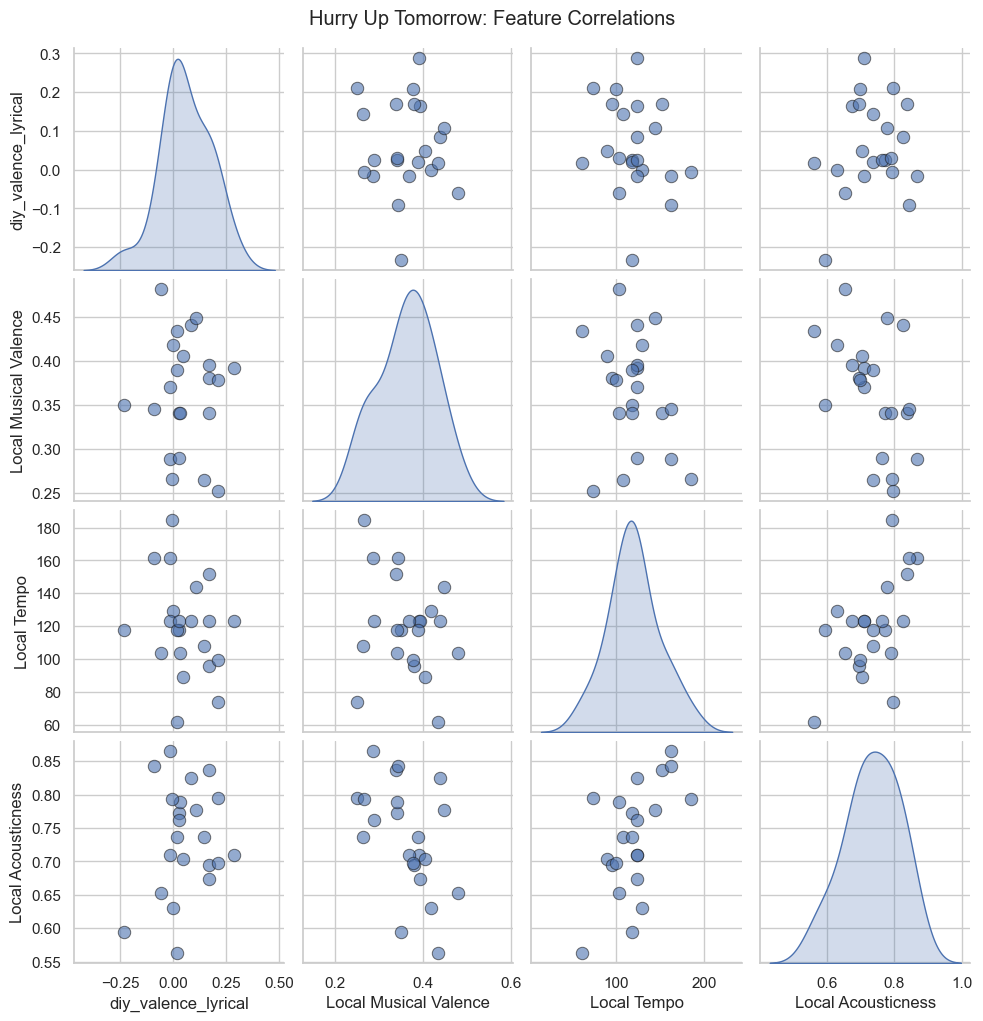

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting the style
sns.set_theme(style="whitegrid")

# Selecting only the numerical columns for the pairplot
cols_to_plot = ['diy_valence_lyrical', 'Local Musical Valence', 'Local Tempo', 'Local Acousticness']

# Creating the grid
sns.pairplot(df_master_HUT[cols_to_plot], diag_kind='kde', plot_kws={'alpha':0.6, 's':80, 'edgecolor':'k'})
plt.suptitle('Hurry Up Tomorrow: Feature Correlations', y=1.02)
plt.show()

### 5.2 Correlation Heatmap
Shows the numerical correlation coefficients between all features. Values close to +1 indicate strong positive correlation, -1 indicates strong negative correlation, and 0 indicates no linear relationship.

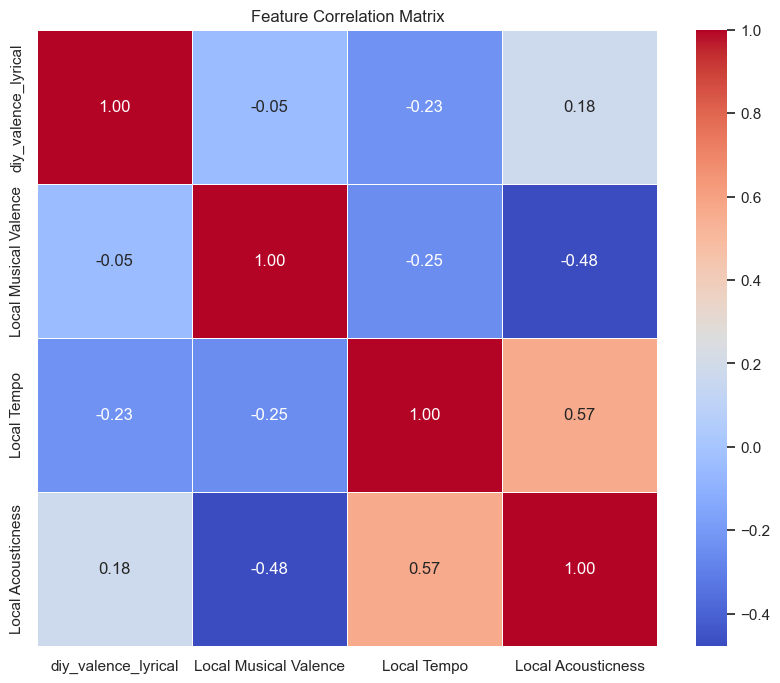

In [85]:
plt.figure(figsize=(10, 8))
corr = df_master_HUT[cols_to_plot].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

### 5.3 Mood Duality Scatter Plot
Compares **lyrical sentiment** (what the words say) vs **musical valence** (how the sound feels). This reveals:
- Songs where sad lyrics meet bright music (or vice versa)
- The size of points represents tempo
- Color represents acousticness

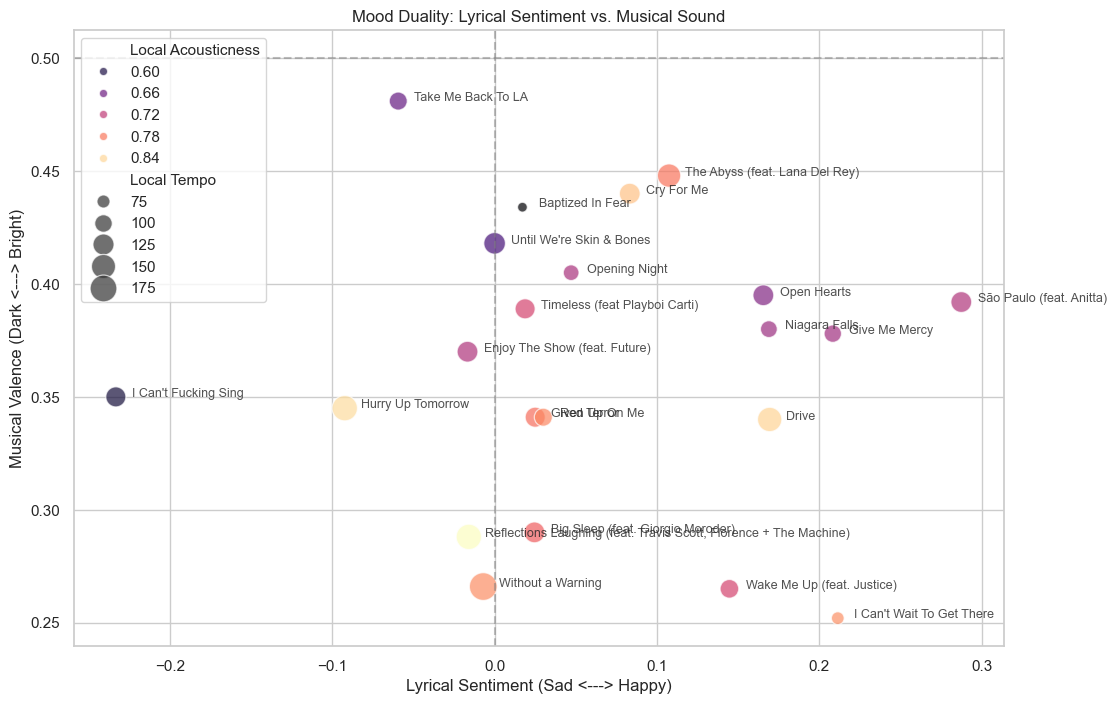

In [86]:
plt.figure(figsize=(12, 8))

# Create the scatter plot
plot = sns.scatterplot(
    data=df_master_HUT, 
    x='diy_valence_lyrical', 
    y='Local Musical Valence', 
    size='Local Tempo', 
    hue='Local Acousticness',
    sizes=(50, 400),
    palette='magma',
    alpha=0.7
)

# Annotate each point with the Track Name
for i in range(df_master_HUT.shape[0]):
    plt.text(
        df_master_HUT.diy_valence_lyrical[i]+0.01, 
        df_master_HUT['Local Musical Valence'][i], 
        df_master_HUT['Track Name'][i], 
        fontsize=9, alpha=0.8
    )

plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5) # Middle line for Sound
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)    # Middle line for Lyrics

plt.title('Mood Duality: Lyrical Sentiment vs. Musical Sound')
plt.xlabel('Lyrical Sentiment (Sad <---> Happy)')
plt.ylabel('Musical Valence (Dark <---> Bright)')
plt.show()

---

## Part 6: Intensity Flow Analysis

### 6.1 Single Track Intensity
Analyzes how the **energy/intensity** of a song changes over time. The RMS (Root Mean Square) energy is:
- Calculated for each moment in the song
- Centered around the average (0 = average intensity)
- Smoothed using a rolling window for cleaner visualization

This reveals the "narrative arc" of how the song builds and releases tension.

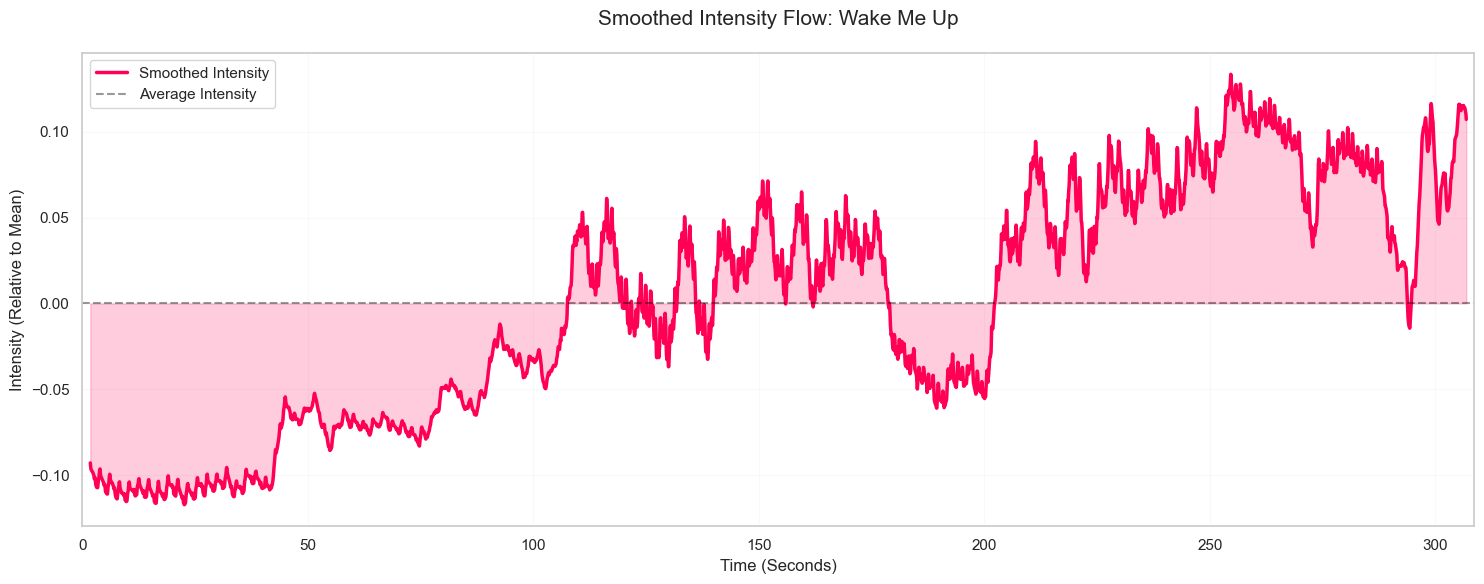

In [87]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_smooth_intensity(file_path, song_name, smoothness=100):
    # 1. Load the audio
    y, sr = librosa.load(file_path)
    
    # 2. Calculate RMS Energy (Intensity)
    rms = librosa.feature.rms(y=y)[0]
    
    # 3. Standardize so 0 = Average
    rms_centered = rms - np.mean(rms)
    
    # 4. SMOOTHING: Use a rolling window
    # Larger 'smoothness' value = flatter, smoother line
    smooth_rms = pd.Series(rms_centered).rolling(window=smoothness, center=True).mean()
    
    # 5. Create Time Axis
    times = librosa.times_like(rms)

    # 6. Plotting
    plt.figure(figsize=(15, 6))
    
    # We plot the smooth line
    plt.plot(times, smooth_rms, color='#ff0055', linewidth=2.5, label='Smoothed Intensity')
    
    # Optional: fill the area under the curve for better visual weight
    plt.fill_between(times, smooth_rms, color='#ff0055', alpha=0.2)
    
    # The Baseline
    plt.axhline(0, color='black', linestyle='--', alpha=0.4, label='Average Intensity')
    
    plt.title(f'Smoothed Intensity Flow: {song_name}', fontsize=15, pad=20)
    plt.xlabel('Time (Seconds)', fontsize=12)
    plt.ylabel('Intensity (Relative to Mean)', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.1)
    
    # Clean up the look
    plt.xlim(0, times[-1])
    plt.tight_layout()
    plt.show()

# Run it on your track
plot_smooth_intensity(r'C:\Users\Syma\Documents\Naraviz\Investigations\Spotify Weekend DIscography\The Weeknd - Hurry Up Tomorrow\01. Wake Me Up.mp3', 'Wake Me Up', smoothness=150)

### 6.2 Intensity Grid - All Tracks
Creates a grid showing the intensity flow for **every track on the album**. This allows you to:
- Compare the narrative arcs across different songs
- Identify which tracks build gradually vs. start intense
- See patterns in how The Weeknd structures his songs

Generating Intensity Maps for 22 tracks...


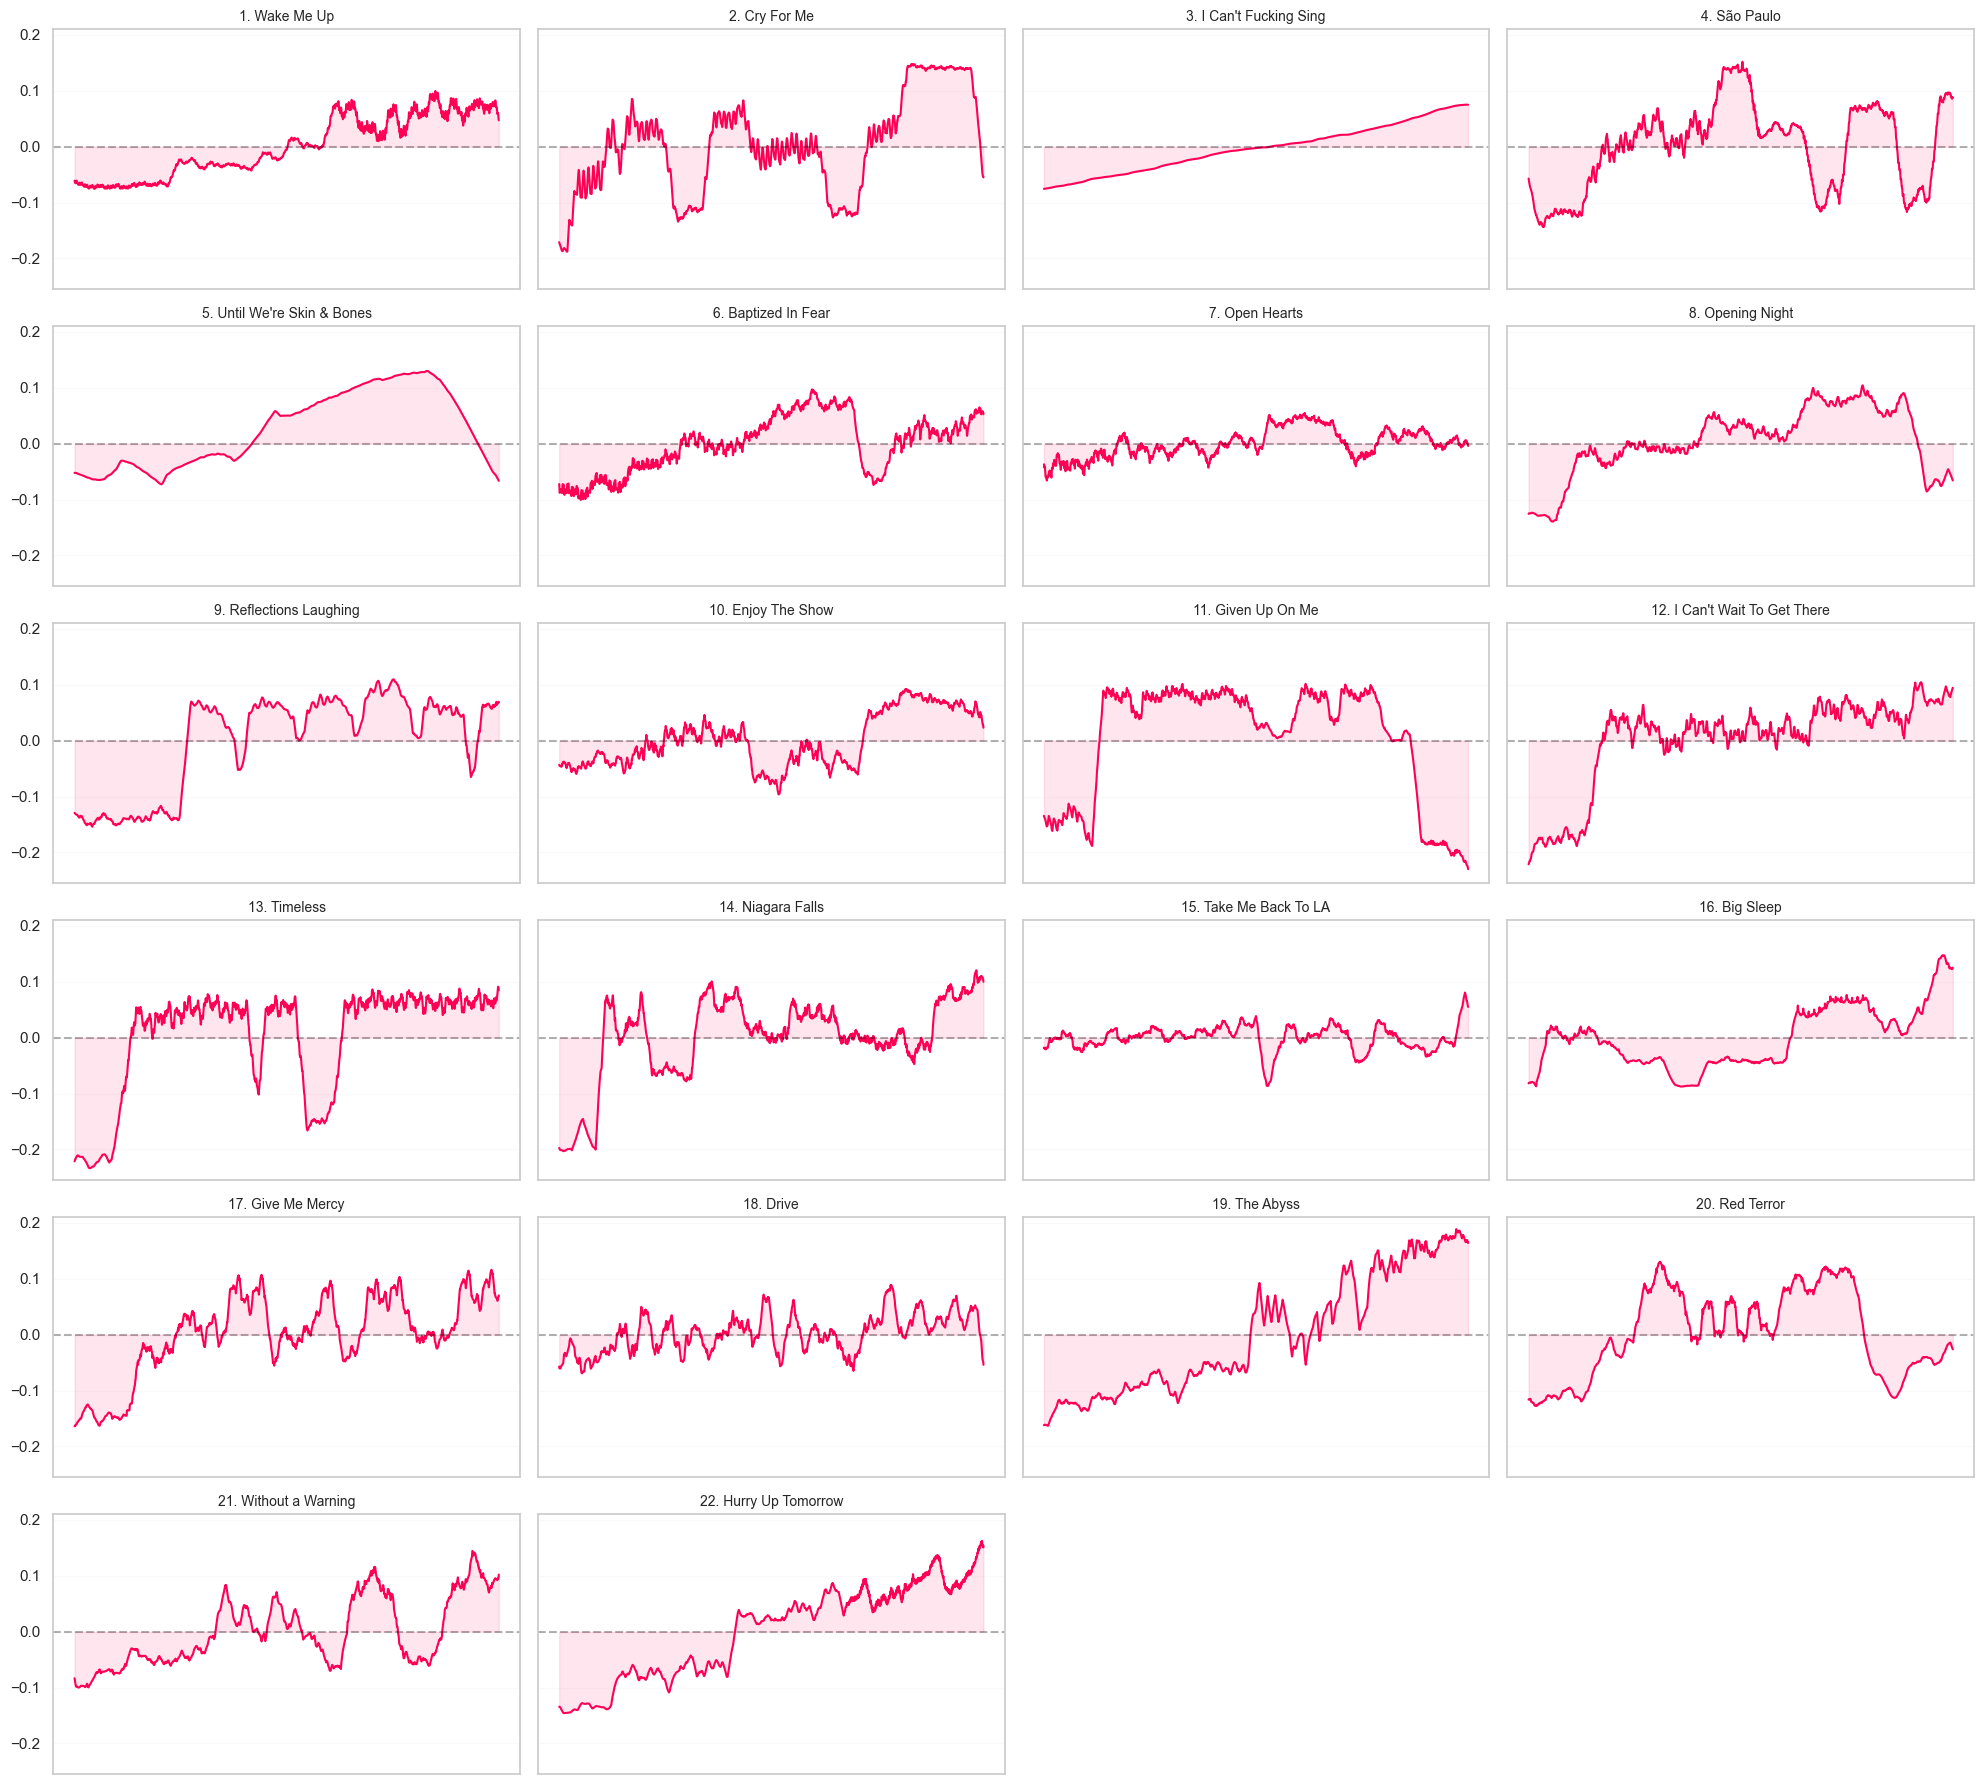

In [88]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# 1. Setup paths and parameters
audio_folder = r'C:\Users\Syma\Documents\Naraviz\Investigations\Spotify Weekend DIscography\The Weeknd - Hurry Up Tomorrow/'
smoothness = 200 # Higher = smoother narrative arc
files = sorted([f for f in os.listdir(audio_folder) if f.endswith('.mp3')])

# 2. Prepare the grid (Example: 6 rows x 4 columns for ~22 tracks)
rows = (len(files) // 4) + 1
fig, axes = plt.subplots(rows, 4, figsize=(20, rows * 3), sharey=True)
axes = axes.flatten()

print(f"Generating Intensity Maps for {len(files)} tracks...")

# 3. The Loop
for i, filename in enumerate(files):
    ax = axes[i]
    path = os.path.join(audio_folder, filename)
    song_name = filename.split('.', 1)[-1].replace('.mp3', '').strip()
    
    try:
        # Load audio (first 3 mins to keep it fast)
        y, sr = librosa.load(path, duration=180) 
        
        # Calculate and center the Intensity (RMS)
        rms = librosa.feature.rms(y=y)[0]
        rms_centered = rms - np.mean(rms)
        
        # Smooth the line using a rolling average
        smooth_rms = pd.Series(rms_centered).rolling(window=smoothness, center=True).mean()
        times = librosa.times_like(rms)
        
        # Plotting on the specific subplot
        ax.plot(times, smooth_rms, color='#ff0055', linewidth=1.5)
        ax.fill_between(times, smooth_rms, color='#ff0055', alpha=0.1)
        ax.axhline(0, color='black', linestyle='--', alpha=0.3)
        
        ax.set_title(f"{i+1}. {song_name}", fontsize=10)
        ax.set_xticks([]) # Hide x-ticks to keep it clean
        ax.grid(alpha=0.1)
        
    except Exception as e:
        print(f"Error on {filename}: {e}")

# 4. Clean up empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 6.3 Dual-Axis: Energy vs Mood Over Time
For each track, this plots **two lines**:
- **Red line (Intensity)**: The power/energy of the sound
- **Blue line (Musical Valence)**: The brightness/mood of the sound

This reveals whether songs get darker as they get louder, or if mood and energy move independently.

Analyzing 22 tracks for Energy vs Mood...


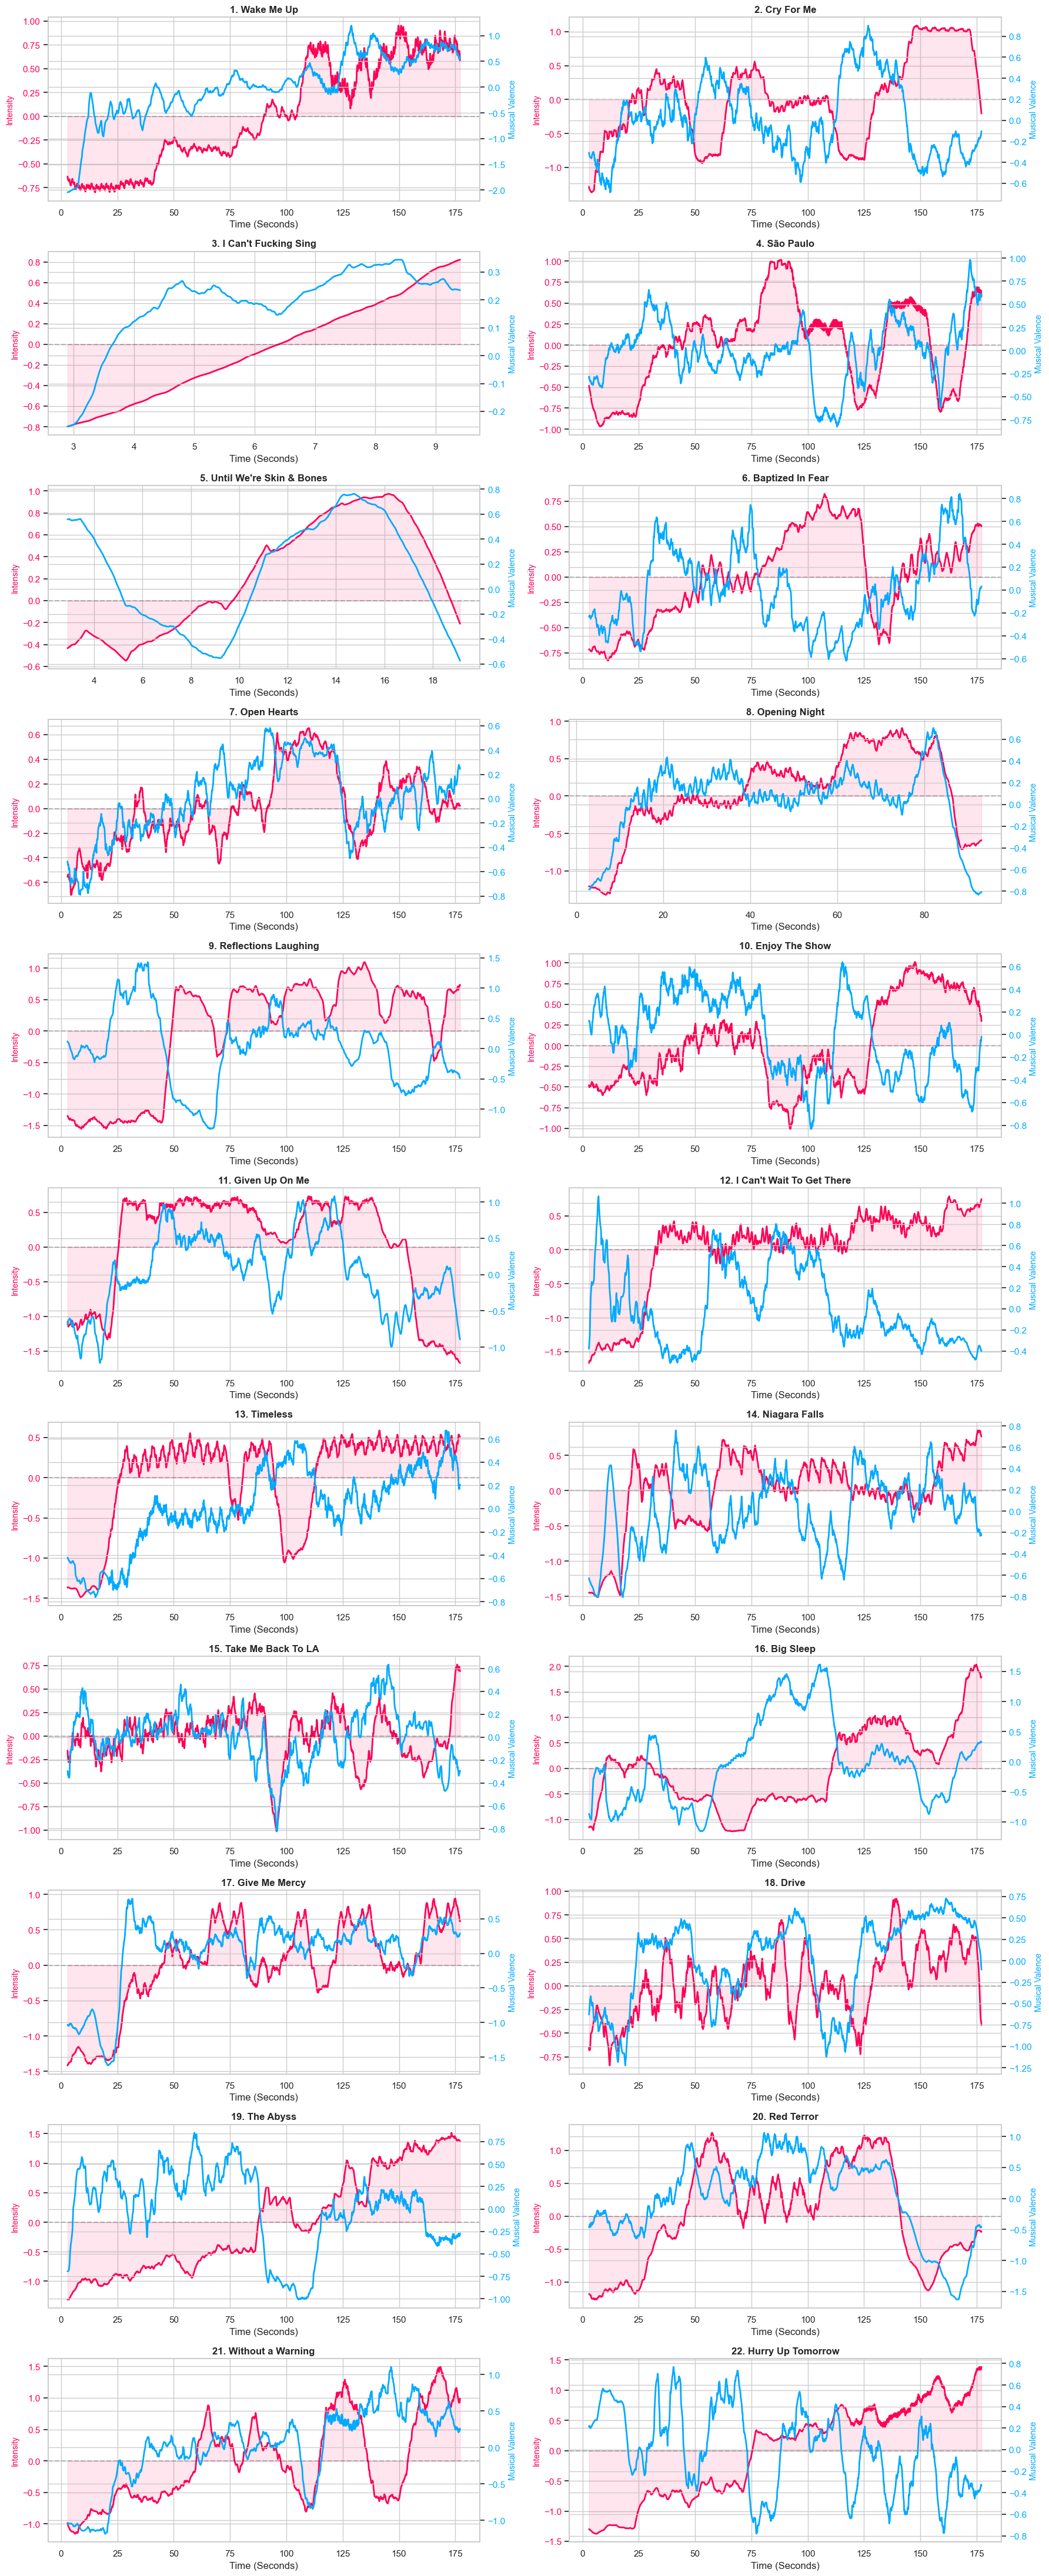

In [89]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# 1. Setup
audio_folder = r'C:\Users\Syma\Documents\Naraviz\Investigations\Spotify Weekend DIscography\The Weeknd - Hurry Up Tomorrow/'
smoothness = 250 # High smoothing for a clean 'narrative' line
files = sorted([f for f in os.listdir(audio_folder) if f.endswith('.mp3')])

# 2. Grid Setup (2 Columns)
cols = 2
rows = (len(files) + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()

print(f"Analyzing {len(files)} tracks for Energy vs Mood...")

# 3. Processing Loop
for i, filename in enumerate(files):
    ax1 = axes[i]
    path = os.path.join(audio_folder, filename)
    song_name = filename.split('.', 1)[-1].replace('.mp3', '').strip()
    
    try:
        # Load audio (limited to 3 mins for speed)
        y, sr = librosa.load(path, duration=180)
        
        # --- INTENSITY (Energy) ---
        rms = librosa.feature.rms(y=y)[0]
        rms_norm = (rms - np.mean(rms)) / np.std(rms) # Z-score normalization
        smooth_energy = pd.Series(rms_norm).rolling(window=smoothness, center=True).mean()
        
        # --- VALENCE (Musical Mood/Brightness) ---
        # We use Spectral Centroid as a proxy for 'Brightness/Positivity'
        cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        cent_norm = (cent - np.mean(cent)) / np.std(cent)
        smooth_valence = pd.Series(cent_norm).rolling(window=smoothness, center=True).mean()
        
        times = librosa.times_like(rms)

        # Plot 1: Intensity (Left Axis)
        ax1.plot(times, smooth_energy, color='#ff0055', linewidth=2, label='Intensity (Power)')
        ax1.fill_between(times, smooth_energy, color='#ff0055', alpha=0.1)
        ax1.set_ylabel('Intensity', color='#ff0055', fontsize=10)
        ax1.tick_params(axis='y', labelcolor='#ff0055')
        
        # Create Plot 2: Valence (Right Axis)
        ax2 = ax1.twinx() 
        ax2.plot(times, smooth_valence, color='#00aaff', linewidth=2, label='Valence (Mood)')
        ax2.set_ylabel('Musical Valence', color='#00aaff', fontsize=10)
        ax2.tick_params(axis='y', labelcolor='#00aaff')

        # Baseline and Title
        ax1.axhline(0, color='black', linestyle='--', alpha=0.2)
        ax1.set_title(f"{i+1}. {song_name}", fontsize=12, fontweight='bold')
        ax1.set_xlabel('Time (Seconds)')
        
    except Exception as e:
        print(f"Error on {filename}: {e}")

# 4. Final Polish
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

---

## Part 7: Statistical Hypothesis Testing

### 7.1 T-Test: Does Mood Affect Tempo?
Splits the album into "positive mood" vs "negative mood" songs and tests whether positive songs are significantly faster. 

**Null Hypothesis**: Mood has no effect on tempo  
**Alternative Hypothesis**: Positive songs have different tempo than negative songs

If p-value < 0.05, the difference is statistically significant.

C:\Users\Syma\AppData\Local\Temp\ipykernel_18252\4032049432.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Positive Mood', 'Negative Mood'],


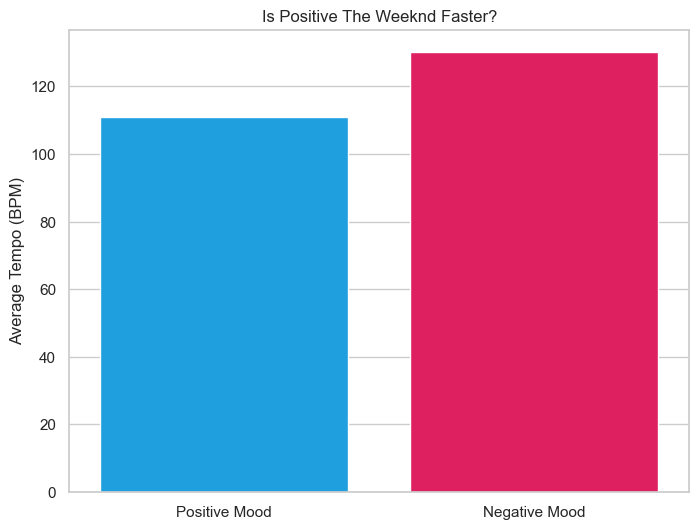

T-Statistic: -1.6156
P-Value: 0.1219
⚖️ NOT SIGNIFICANT: The energy is independent of the mood on this album.


In [90]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define the "Split Point" (The average mood of the album)
mean_valence = df_master_HUT['Local Musical Valence'].mean()

# 2. Split the master table into two groups
positive_songs = df_master_HUT[df_master_HUT['Local Musical Valence'] > mean_valence]['Local Tempo']
negative_songs = df_master_HUT[df_master_HUT['Local Musical Valence'] <= mean_valence]['Local Tempo']

# 3. Perform the Independent T-Test
t_stat, p_val = stats.ttest_ind(positive_songs, negative_songs)

# 4. Visualize the comparison
plt.figure(figsize=(8, 6))
sns.barplot(x=['Positive Mood', 'Negative Mood'], 
            y=[positive_songs.mean(), negative_songs.mean()],
            palette=['#00aaff', '#ff0055'])

plt.title('Is Positive The Weeknd Faster?')
plt.ylabel('Average Tempo (BPM)')
plt.show()

# 5. Output the verdict
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_val:.4f}")

if p_val < 0.05:
    print("✨ STATISTICALLY SIGNIFICANT: The mood definitely affects the energy!")
else:
    print("⚖️ NOT SIGNIFICANT: The energy is independent of the mood on this album.")

### 7.2 Correlation Test: Album Progression
Tests whether the album's **energy changes** from the first track to the last. A negative correlation would mean the album "winds down," positive would mean it "ramps up."

**Pearson's r**: Measures the strength and direction of the linear relationship  
**P-value**: Determines if the correlation is statistically significant

In [91]:
from scipy.stats import pearsonr

# 1. Calculate Pearson Correlation (r) and P-value
# We compare Track Number vs Local Tempo (or Musical Valence)
r_val, p_val = pearsonr(df_master_HUT['Track Number'], df_master_HUT['Local Tempo'])

print(f"Correlation (r): {r_val:.3f}")
print(f"P-Value: {p_val:.4f}")

if p_val < 0.05:
    direction = "decreases" if r_val < 0 else "increases"
    print(f"✅ SIGNIFICANT: As the album progresses, the energy {direction}.")
else:
    print("⚖️ NOT SIGNIFICANT: The album's energy doesn't follow a linear front-to-back trend.")

Correlation (r): 0.354
P-Value: 0.1063
⚖️ NOT SIGNIFICANT: The album's energy doesn't follow a linear front-to-back trend.


### 7.3 One-Sample T-Test: Acousticness vs Industry
Compares the album's average acousticness to the typical Spotify baseline (~0.15). This tests whether "Hurry Up Tomorrow" is more acoustic/organic or more electronic than typical mainstream music.

In [92]:
# 2. Compare the album's average to the industry baseline
t_stat, p_val = stats.ttest_1samp(df_master_HUT['Local Acousticness'], 0.15)

print(f"T-Statistic: {t_stat:.4f} | P-Value: {p_val:.4f}")

if p_val < 0.05:
    avg = df_master_HUT['Local Acousticness'].mean()
    status = "more acoustic" if avg > 0.15 else "more electronic"
    print(f"✨ SUCCESS: This album is statistically {status} than the industry average.")

T-Statistic: 33.9899 | P-Value: 0.0000
✨ SUCCESS: This album is statistically more acoustic than the industry average.


### 7.4 Chi-Square Test: Mood vs Tempo Independence
Tests whether **lyrical mood** and **tempo** are independent variables or if certain moods "demand" certain speeds.

Creates a contingency table (Happy/Sad × Fast/Slow) and performs a chi-square test. If p < 0.05, there's a significant pattern linking mood to tempo.

In [93]:
# 3. Categorize the data
df_master_HUT['mood_type'] = df_master_HUT['diy_valence_lyrical'].apply(lambda x: 'Happy' if x > 0 else 'Sad')
df_master_HUT['tempo_type'] = df_master_HUT['Local Tempo'].apply(lambda x: 'Fast' if x > 115 else 'Slow')

# Create a Contingency Table (Cross-tab)
contingency_table = pd.crosstab(df_master_HUT['mood_type'], df_master_HUT['tempo_type'])
print(contingency_table)

# Perform Chi-Square Test
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)

print(f"\nChi-Square P-Value: {p:.4f}")
if p < 0.05:
    print("🎯 SIGNIFICANT: Mood and Tempo are linked! Certain moods 'demand' certain speeds.")
else:
    print("🎲 INDEPENDENT: He mixes any mood with any speed. No predictable pattern.")

tempo_type  Fast  Slow
mood_type             
Happy          8     7
Sad            6     1

Chi-Square P-Value: 0.3198
🎲 INDEPENDENT: He mixes any mood with any speed. No predictable pattern.


---

## Part 8: Regression Analysis

### 8.1 Linear Regression: Valence Predicts Tempo
Builds a regression model to predict tempo from musical valence. This answers: **"For every unit increase in brightness, how many BPM does the tempo increase?"**

**Key Outputs**:
- **Slope (Coefficient)**: The rate of change (BPM per valence unit)
- **R-squared**: How much of the tempo variation is explained by valence
- **P-value**: Whether the relationship is statistically significant

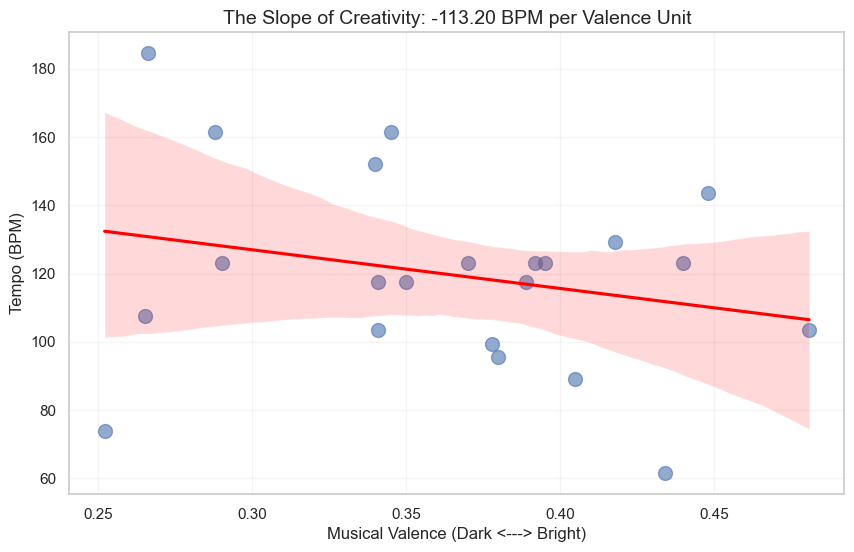

--- REGRESSION RESULTS ---
Slope (Coefficient): -113.20
P-Value: 0.2660
R-Squared (Accuracy): 0.0615


In [94]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare the data
# X is the predictor (Valence), y is the outcome (Tempo)
X = df_master_HUT['Local Musical Valence']
y = df_master_HUT['Local Tempo']

# Add a constant (intercept) to the model
X_with_const = sm.add_constant(X)

# 2. Fit the Ordinary Least Squares (OLS) Model
model = sm.OLS(y, X_with_const).fit()

# 3. Extract the "Slope" (Coefficient)
slope = model.params['Local Musical Valence']
p_value = model.pvalues['Local Musical Valence']
r_squared = model.rsquared

# 4. Visualize the Regression Line
plt.figure(figsize=(10, 6))
sns.regplot(x='Local Musical Valence', y='Local Tempo', data=df_master_HUT, 
            scatter_kws={'s':100, 'alpha':0.6}, line_kws={'color':'red'})

plt.title(f'The Slope of Creativity: {slope:.2f} BPM per Valence Unit', fontsize=14)
plt.xlabel('Musical Valence (Dark <---> Bright)')
plt.ylabel('Tempo (BPM)')
plt.grid(alpha=0.2)
plt.show()

print(f"--- REGRESSION RESULTS ---")
print(f"Slope (Coefficient): {slope:.2f}")
print(f"P-Value: {p_value:.4f}")
print(f"R-Squared (Accuracy): {r_squared:.4f}")

### 8.2 Outlier Detection: Finding Experimental Tracks
Uses the regression model to identify **outliers** - songs that don't follow the album's typical valence-tempo pattern.

**Method**:
1. Predict what the tempo "should be" based on valence
2. Calculate the residual (actual - predicted)
3. Flag songs more than 1.5 standard deviations away as outliers

These outliers represent the most "experimental" or rule-breaking moments on the album.

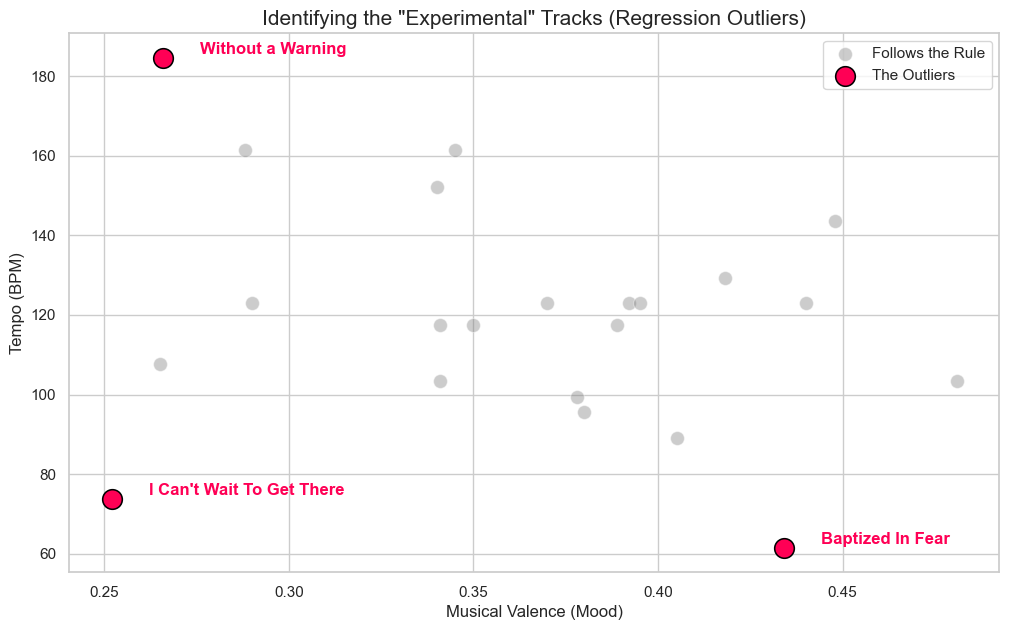

--- THE EXPERIMENTAL OUTLIERS ---
                   Track Name  Local Tempo   residual
5            Baptized In Fear        61.52 -50.276247
11  I Can't Wait To Get There        73.83 -58.568004
20          Without a Warning       184.57  53.756746


In [95]:
import numpy as np

# 1. Calculate the 'Predicted' Tempo based on the model
# Using the model we just built: y_pred = intercept + (slope * valence)
df_master_HUT['predicted_tempo'] = model.predict(X_with_const)

# 2. Calculate the Residuals (Actual - Predicted)
df_master_HUT['residual'] = df_master_HUT['Local Tempo'] - df_master_HUT['predicted_tempo']

# 3. Identify Outliers
# We'll define outliers as songs more than 1.5 Standard Deviations away
residual_threshold = df_master_HUT['residual'].std() * 1.5
df_master_HUT['is_outlier'] = df_master_HUT['residual'].abs() > residual_threshold

# 4. Visualize the outliers
plt.figure(figsize=(12, 7))

# Plot normal songs
sns.scatterplot(data=df_master_HUT[df_master_HUT['is_outlier'] == False], 
                x='Local Musical Valence', y='Local Tempo', 
                color='gray', alpha=0.4, s=100, label='Follows the Rule')

# Plot outliers in bright red
sns.scatterplot(data=df_master_HUT[df_master_HUT['is_outlier'] == True], 
                x='Local Musical Valence', y='Local Tempo', 
                color='#ff0055', s=200, edgecolor='black', label='The Outliers')

# Label the outliers
for i, row in df_master_HUT[df_master_HUT['is_outlier'] == True].iterrows():
    plt.text(row['Local Musical Valence']+0.01, row['Local Tempo']+1, 
             row['Track Name'], fontweight='bold', color='#ff0055')

plt.title('Identifying the "Experimental" Tracks (Regression Outliers)', fontsize=15)
plt.xlabel('Musical Valence (Mood)')
plt.ylabel('Tempo (BPM)')
plt.legend()
plt.show()

# Display the Outlier Table
print("--- THE EXPERIMENTAL OUTLIERS ---")
print(df_master_HUT[df_master_HUT['is_outlier'] == True][['Track Name', 'Local Tempo', 'residual']])

---

## Part 9: DNA Visualization

### 9.1 Album DNA (Average)
Creates a **radar chart** showing the album's overall "sonic fingerprint" across four dimensions:
- Lyrical mood (sentiment)
- Acousticness (organic vs electronic)
- Tempo (energy/speed)
- Musical valence (sonic brightness)

All values are normalized to 0-1 scale for fair comparison.

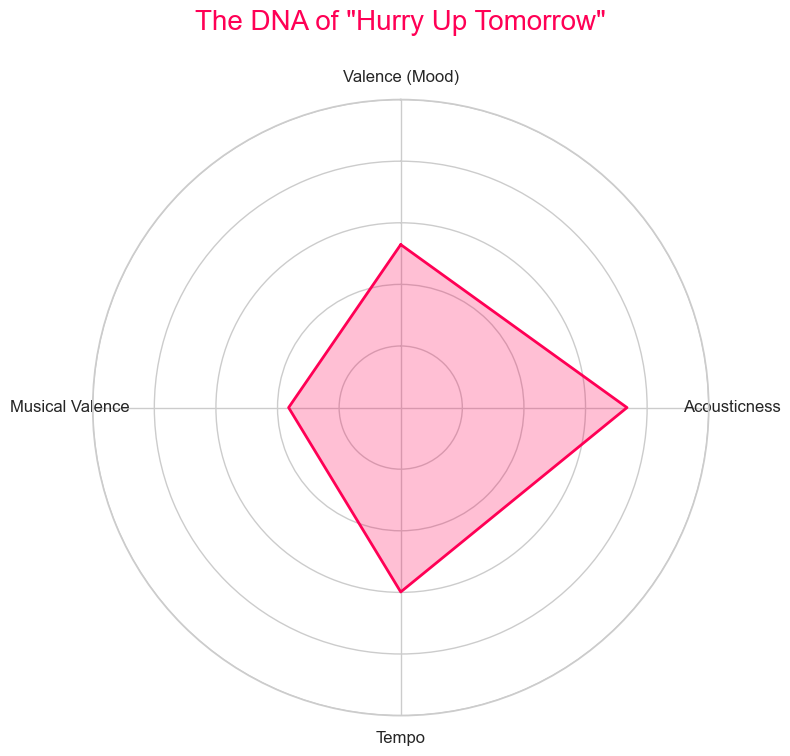

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepare the Data (Averages)
# We select the features we want to see in the DNA
categories = ['Valence (Mood)', 'Acousticness', 'Tempo', 'Musical Valence']
values = [
    df_master_HUT['diy_valence_lyrical'].mean(),
    df_master_HUT['Local Acousticness'].mean(),
    df_master_HUT['Local Tempo'].mean(),
    df_master_HUT['Local Musical Valence'].mean()
]

# 2. Normalize the values to a 0-1 scale for the chart
# (Tempo is divided by 200 as a max BPM reference)
values_norm = [
    (values[0] + 1) / 2, # Shift sentiment from -1/1 to 0/1
    values[1],
    values[2] / 200,
    values[3]
]

# 3. Create the Radar Chart Geometry
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# "Close the loop" by appending the start to the end
values_norm += values_norm[:1]
angles += angles[:1]

# 4. Plotting
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw the polygon
ax.fill(angles, values_norm, color='#ff0055', alpha=0.25)
ax.plot(angles, values_norm, color='#ff0055', linewidth=2)

# Label each axis
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)

# Set the radial limits (0 to 1)
ax.set_ylim(0, 1)
ax.set_yticklabels([]) # Hide the numbers to keep it clean

plt.title('The DNA of "Hurry Up Tomorrow"', size=20, color='#ff0055', y=1.1)
plt.show()

### 9.2 Individual Track DNA Grid
Creates a **radar chart for every track** on the album. This allows you to:
- See each song's unique fingerprint
- Compare tracks side-by-side
- Identify which songs are similar or different in their audio/lyrical profile

**Color coding**: Red for fast tracks (>120 BPM), blue for slower tracks.

Generating DNA Radar Charts for 22 tracks...


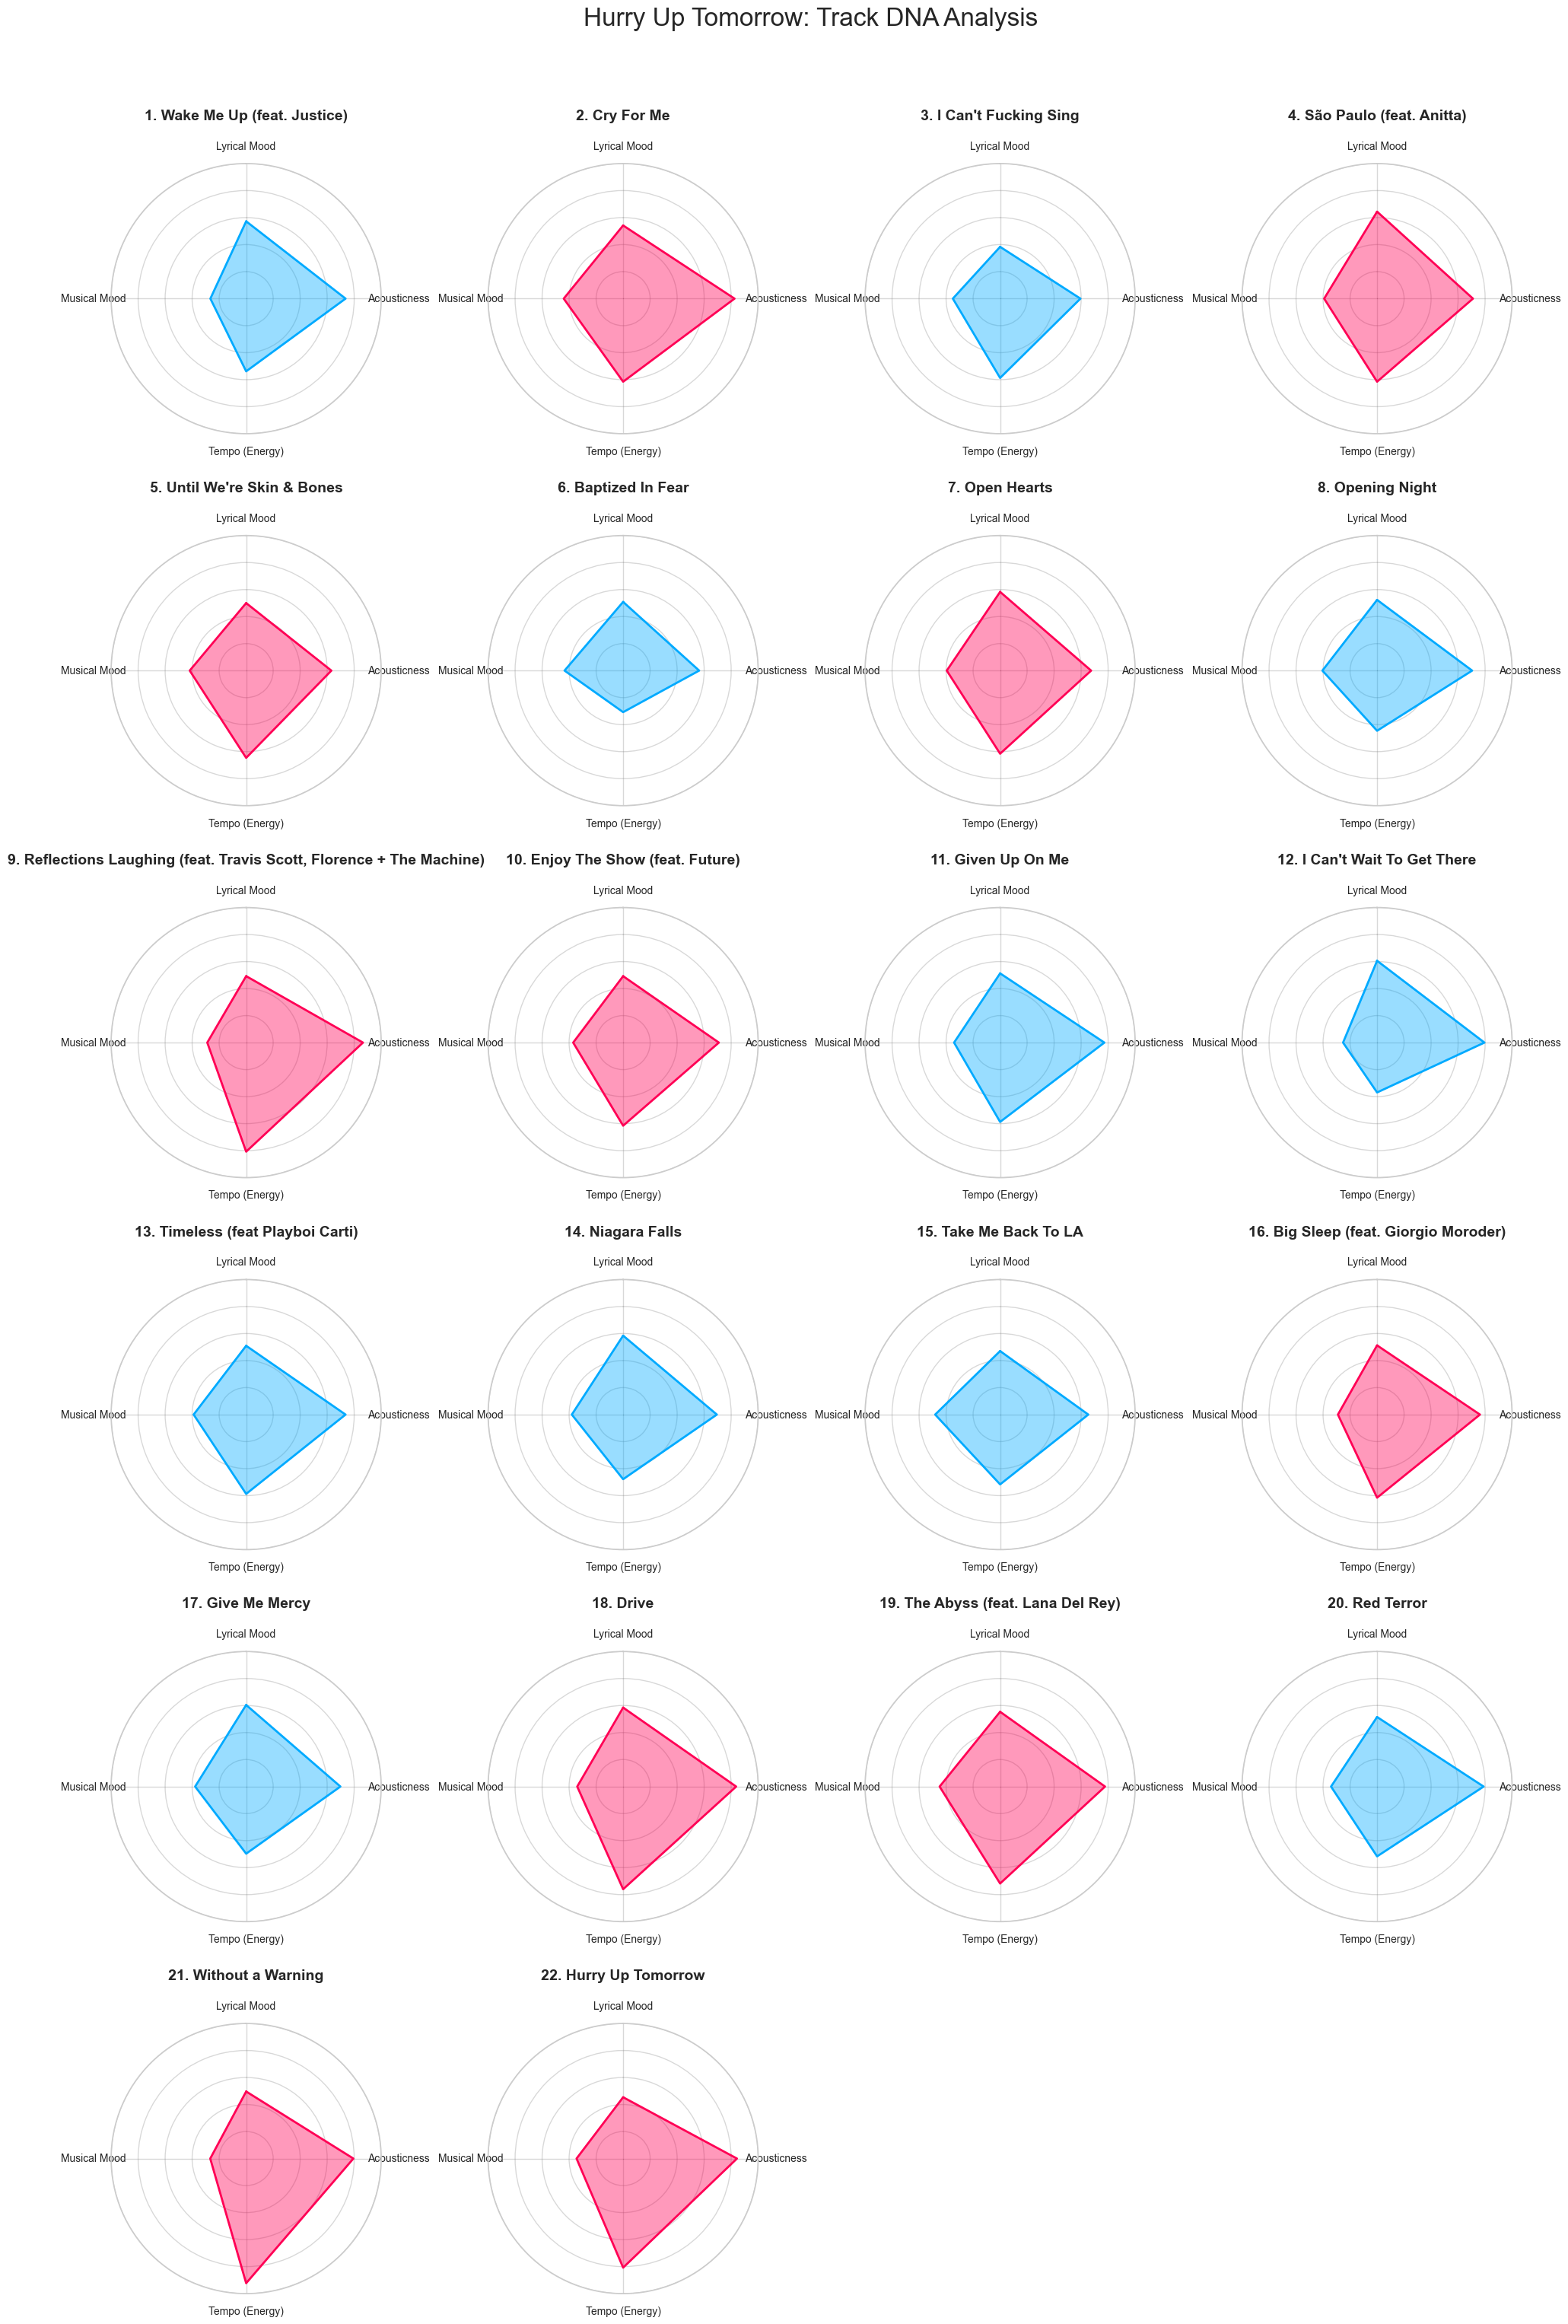

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. SETUP & PREPARATION ---
# Define the features we want in the DNA
categories = ['Lyrical Mood', 'Acousticness', 'Tempo (Energy)', 'Musical Mood']
num_vars = len(categories)

# Calculate the angles for the radar chart axes
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
# "Close the loop" by appending the start angle to the end
angles += angles[:1]

# Helper function to normalize values to a 0-1 scale
# This ensures all axes are comparable on the radar chart
def get_normalized_values(row):
    # 1. Lyrical Valence: Convert from [-1, 1] scale to [0, 1]
    lyrical = (row['diy_valence_lyrical'] + 1) / 2 
    # 2. Acousticness: Already [0, 1]
    acoustic = row['Local Acousticness']
    # 3. Tempo: Normalize against a max of 200 BPM
    tempo = min(row['Local Tempo'] / 200, 1.0)
    # 4. Musical Valence: Already approx [0, 1]
    musical = min(max(row['Local Musical Valence'], 0), 1.0) # Ensure it stays within bounds
    
    values = [lyrical, acoustic, tempo, musical]
    # Close the loop for plotting
    values += values[:1]
    return values

# --- 2. GRID SETUP ---
num_tracks = len(df_master_HUT)
cols = 4 # Number of columns in the grid
rows = (num_tracks // cols) + 1

# Create the figure with polar subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5), subplot_kw=dict(polar=True))
axes = axes.flatten()

print(f"Generating DNA Radar Charts for {num_tracks} tracks...")

# --- 3. THE MAIN LOOP ---
for i, (index, row) in enumerate(df_master_HUT.iterrows()):
    ax = axes[i]
    track_name = row['Track Name']
    
    # Get the normalized DNA values for this track
    values = get_normalized_values(row)
    
    # Plot the data
    # Change color based on overall vibe if you want (e.g., red for fast, blue for slow)
    color = '#ff0055' if row['Local Tempo'] > 120 else '#00aaff'
    
    ax.fill(angles, values, color=color, alpha=0.4)
    ax.plot(angles, values, color=color, linewidth=2)
    
    # Fix the axis labels so they are readable
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=10)
    
    # Ensure the radial limit is strictly 0 to 1 and hide inner labels
    ax.set_ylim(0, 1)
    ax.set_yticklabels([])
    ax.grid(color='gray', alpha=0.3)
    
    # Add title with track number
    ax.set_title(f"{row['Track Number']}. {track_name}", size=14, weight='bold', pad=20)

# --- 4. FINAL POLISH ---
# Remove empty subplots if the grid isn't full
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a main title to the entire image
fig.suptitle('Hurry Up Tomorrow: Track DNA Analysis', size=24, y=1.02)
plt.tight_layout()
plt.show()

In [98]:
df_master_HUT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Track Number           22 non-null     int64  
 1   Track Name             22 non-null     object 
 2   diy_valence_lyrical    22 non-null     float64
 3   Local Musical Valence  22 non-null     float64
 4   Local Tempo            22 non-null     float64
 5   Local Acousticness     22 non-null     float64
 6   Unique ID              22 non-null     object 
 7   mood_type              22 non-null     object 
 8   tempo_type             22 non-null     object 
 9   predicted_tempo        22 non-null     float64
 10  residual               22 non-null     float64
 11  is_outlier             22 non-null     bool   
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 2.0+ KB


DAWN FM



In [99]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

# 1. Setup your credentials
client_id = '5bb46020f8ce47968a90ddcd6456d29f'
client_secret = '8a3c739aadc24addbce5b1e30123df5b'

auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

# 2. Your chosen Album ID (Hurry Up Tomorrow)
album_id = '2nLOHgzXzwFEpl62zAgCEC'

def get_album_tracklist(id):
    # Fetch track data from the API
    results = sp.album_tracks(id)
    tracks = results['items']
    
    # Handle pagination if the album has more than 50 tracks
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
        
    # Extract the specific fields we want
    track_data = []
    for track in tracks:
        track_data.append({
            'Track Number': track['track_number'],
            'Track Name': track['name'],
            'Unique ID': track['id']
        })
    
    # Create the DataFrame
    return pd.DataFrame(track_data)

# 3. Execute and display
df_tracks_HUT = get_album_tracklist(album_id)
print(df_tracks_HUT.head(10)) # Shows the first 10 tracks

   Track Number                                    Track Name  \
0             1                                       Dawn FM   
1             2                                      Gasoline   
2             3                    How Do I Make You Love Me?   
3             4                                Take My Breath   
4             5                                     Sacrifice   
5             6                              A Tale By Quincy   
6             7                                   Out of Time   
7             8  Here We Go… Again (feat. Tyler, the Creator)   
8             9                                  Best Friends   
9            10                        Is There Someone Else?   

                Unique ID  
0  6krYS8KtmNAYyb5uTZiYW4  
1  3KyKxJ4P3pVCgaZwaq2rUC  
2  2Ghp894n1laIf2w98VeAOJ  
3  2vgUijXOTRMnWXDtvgMp2b  
4  1nH2PkJL1XoUq8oE6tBZoU  
5  759ndr57jb0URg4j9YSWml  
6  2SLwbpExuoBDZBpjfefCtV  
7  1NhjYYcYTRywc0di98xHxf  
8  1E5Xu8dur0fAjSP1VpVhAZ  
9  0

In [105]:
import os
import time
import pandas as pd
import numpy as np
import librosa
from textblob import TextBlob
import lyricsgenius
import statsmodels.api as sm

# ==========================================
# 1. SETTINGS FOR THE CURRENT ALBUM
# ==========================================
ALBUM_FOLDER = r'C:\Users\Syma\Documents\Naraviz\Investigations\Spotify Weekend DIscography\The Weeknd - Dawn FM'  # Folder containing [id].[Name].mp3
ALBUM_SUFFIX = 'DFM'                   # AHR, DFM, or HUT
ARTIST_NAME = "The Weeknd"

# Ensure these match your existing credentials
GENIUS_TOKEN = "a4Hr7now_xOQEKzg95w-arraV8s6UK3STpyxHrJF9DNL8ocyKVIqkgyyjc9qEnre" 
genius = lyricsgenius.Genius(GENIUS_TOKEN, verbose=False, remove_section_headers=True)

def generate_master_df(folder_path, suffix, spotify_df):
    """
    Replicates the exact df_master structure for a new album.
    spotify_df: The dataframe you already got from the Spotify API for this album.
    """
    print(f"🚀 Processing Master DF for {suffix}...")
    
    # --- Part 1: Audio Analysis (Librosa) ---
    audio_results = []
    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.mp3')])
    
    for filename in files:
        # Extract ID from "01. Song Name.mp3"
        track_num = int(filename.split('.')[0])
        path = os.path.join(folder_path, filename)
        
        y, sr = librosa.load(path, duration=60) # Analyze first 60s for speed
        
        # Tempo
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        
        # Acousticness (Harmonic/Percussive Ratio)
        y_har, y_per = librosa.effects.hpss(y)
        har_rms = np.mean(librosa.feature.rms(y=y_har))
        total_rms = np.mean(librosa.feature.rms(y=y))
        acoustic = har_rms / total_rms
        
        # Musical Valence (Spectral Centroid proxy)
        cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        musical_val = np.mean(cent) / 5000
        
        audio_results.append({
            'Track Number': track_num,
            'Local Tempo': float(tempo),
            'Local Acousticness': float(acoustic),
            'Local Musical Valence': float(musical_val)
        })

    df_audio = pd.DataFrame(audio_results)

    # --- Part 2: Combine with Spotify Metadata ---
    # Merge on Track Number
    df_merged = pd.merge(spotify_df, df_audio, on='Track Number', how='inner')

    # --- Part 3: Sentiment Analysis (TextBlob) ---
    for index, row in df_merged.iterrows():
        try:
            clean_name = row['Track Name'].split('(')[0].split('-')[0].strip()
            song = genius.search_song(clean_name, ARTIST_NAME)
            if song and len(song.lyrics) > 20:
                df_merged.at[index, 'diy_valence_lyrical'] = TextBlob(song.lyrics).sentiment.polarity
            else:
                df_merged.at[index, 'diy_valence_lyrical'] = 0.0
        except:
            df_merged.at[index, 'diy_valence_lyrical'] = 0.0
        time.sleep(1) # Delay for Genius API

    # --- Part 4: Replicating Statistical Columns ---
    df_merged['mood_type'] = df_merged['diy_valence_lyrical'].apply(lambda x: 'Happy' if x > 0 else 'Sad')
    df_merged['tempo_type'] = df_merged['Local Tempo'].apply(lambda x: 'Fast' if x > 115 else 'Slow')
    
    # Regression Logic (Required for the 'residual' and 'predicted' columns in your original df_master)
    X = sm.add_constant(df_merged['Local Musical Valence'])
    model = sm.OLS(df_merged['Local Tempo'], X).fit()
    df_merged['predicted_tempo'] = model.predict(X)
    df_merged['residual'] = df_merged['Local Tempo'] - df_merged['predicted_tempo']
    df_merged['is_outlier'] = df_merged['residual'].abs() > (df_merged['residual'].std() * 1.5)
    
    # Ensure columns match your specific df_master order
    final_cols = [
        'Track Number', 'Track Name', 'diy_valence_lyrical', 'Local Musical Valence',
        'Local Tempo', 'Local Acousticness', 'Unique ID', 'mood_type', 'tempo_type',
        'predicted_tempo', 'residual', 'is_outlier'
    ]
    
    return df_merged[final_cols]

# EXECUTING: This creates df_master_DFM or df_master_AHR
# Note: Ensure 'df_tracks_dawn' (or whatever you named your spotify api result) is passed here
globals()[f"df_master_{ALBUM_SUFFIX}"] = generate_master_df(ALBUM_FOLDER, ALBUM_SUFFIX, df_tracks_HUT)

print(f"Done! Created df_master_{ALBUM_SUFFIX}")

🚀 Processing Master DF for DFM...


C:\Users\Syma\AppData\Local\Temp\ipykernel_18252\2936835698.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Local Tempo': float(tempo),


Done! Created df_master_DFM


In [106]:
df_master_DFM.head()


,Track Number,Track Name,diy_valence_lyrical,Local Musical Valence,Local Tempo,Local Acousticness,Unique ID,mood_type,tempo_type,predicted_tempo,residual,is_outlier
0,1,Dawn FM,0.110000,0.386178,123.046875,0.900233,6krYS8KtmNAYyb5uTZiYW4,Happy,Fast,126.293306,-3.246431,False
1,2,Gasoline,0.000000,0.427729,123.046875,0.730646,3KyKxJ4P3pVCgaZwaq2rUC,Sad,Fast,122.877095,0.169780,False
2,3,How Do I Make You Love Me?,0.103247,0.505363,123.046875,0.617836,2Ghp894n1laIf2w98VeAOJ,Happy,Fast,116.494288,6.552587,False
3,4,Take My Breath,0.000000,0.474493,123.046875,0.541634,2vgUijXOTRMnWXDtvgMp2b,Sad,Fast,119.032307,4.014568,False
4,5,Sacrifice,0.000000,0.465670,123.046875,0.670863,1nH2PkJL1XoUq8oE6tBZoU,Sad,Fast,119.757700,3.289175,False


In [108]:
import time
import requests

def resilient_valence_fix(df, artist="The Weeknd"):
    print("🛡️ Starting Resilient Healing (with retry logic)...")
    
    for index, row in df.iterrows():
        # Only process tracks that are still 0.0
        if row['diy_valence_lyrical'] == 0.0:
            track_name = row['Track Name'].split('(')[0].split('-')[0].strip()
            
            success = False
            retries = 0
            max_retries = 3
            
            while not success and retries < max_retries:
                try:
                    song = genius.search_song(track_name, artist)
                    if song:
                        val = TextBlob(song.lyrics).sentiment.polarity
                        df.at[index, 'diy_valence_lyrical'] = val
                        print(f"✨ Success: {track_name} -> {val:.3f}")
                    else:
                        print(f"❓ Not Found: {track_name}")
                    
                    success = True # Break the while loop
                    
                except (requests.exceptions.RequestException, Exception) as e:
                    retries += 1
                    wait_time = retries * 5 # Wait 5s, then 10s, then 15s
                    print(f"⚠️ Connection error on {track_name}. Retrying in {wait_time}s... ({retries}/{max_retries})")
                    time.sleep(wait_time)
            
            # mandatory rest between different songs
            time.sleep(2) 

    # Update categories
    df['mood_type'] = df['diy_valence_lyrical'].apply(lambda x: 'Happy' if x > 0.01 else ('Sad' if x < -0.01 else 'Neutral'))
    return df

# Run it again
df_master_DFM = resilient_valence_fix(df_master_DFM)

🛡️ Starting Resilient Healing (with retry logic)...
✨ Success: A Tale By Quincy -> 0.048
⚠️ Connection error on Best Friends. Retrying in 5s... (1/3)
⚠️ Connection error on Best Friends. Retrying in 10s... (2/3)


KeyboardInterrupt: 

In [ ]:
df_master_DFM.head()